<h1>Landsat 8/9 imagery analysis and building indices for the USA </h1>

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [1]:
#!pip install earthpy gdal

<h3>Import Modules</h3>

In [2]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

#Set treatment for all types of floating-point errors at once:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
import os
os.getcwd()

'D:\\python_projects\\Satellite_Imagery_Analysis'

In [4]:
%cd input/USA_data

D:\python_projects\Satellite_Imagery_Analysis\input\USA_data


<h3>Read data</h3>

In [5]:
landsat = glob(r"D:\python_projects\Satellite_Imagery_Analysis\input\USA_data\*B[1-7,9].TIF")
landsat.sort()
landsat

['D:\\python_projects\\Satellite_Imagery_Analysis\\input\\USA_data\\LO09_L1TP_014031_20220314_20220314_02_T1_B1.TIF',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\USA_data\\LO09_L1TP_014031_20220314_20220314_02_T1_B2.TIF',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\USA_data\\LO09_L1TP_014031_20220314_20220314_02_T1_B3.TIF',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\USA_data\\LO09_L1TP_014031_20220314_20220314_02_T1_B4.TIF',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\USA_data\\LO09_L1TP_014031_20220314_20220314_02_T1_B5.TIF',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\USA_data\\LO09_L1TP_014031_20220314_20220314_02_T1_B6.TIF',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\USA_data\\LO09_L1TP_014031_20220314_20220314_02_T1_B7.TIF',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\USA_data\\LO09_L1TP_014031_20220314_20220314_02_T1_B9.TIF']

In [6]:
list = []
for i in landsat:
  with rio.open(i, 'r') as f:
    list.append(f.read(1))

arr_land = np.stack(list)

arr_land.shape

(8, 7841, 7731)

<h3>Data Visualization</h3>

<h4>Visualize Bands</h4>

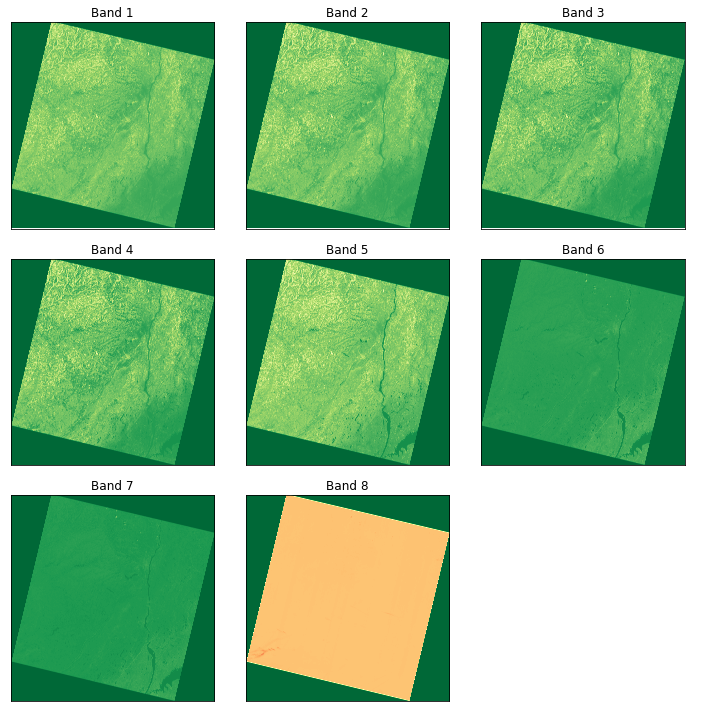

In [21]:
ep.plot_bands(arr_land,
              cmap='RdYlGn_r',
              cols=3,
              figsize=(10, 10),
              cbar=False)
plt.show()

<h4>Histograms</h4>

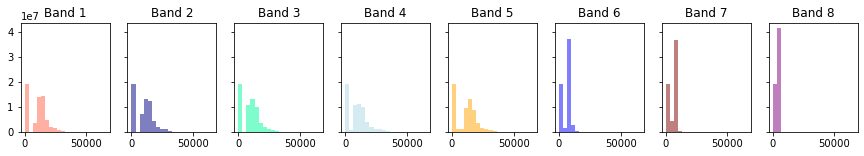

In [14]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_land, 
        colors = colors,
        title=[f'Band {i}' for i in range(1, 9)], 
        cols=8, 
        alpha=0.5, 
        figsize = (15, 2))

plt.show()

<h4>RGB Composite Image</h4>

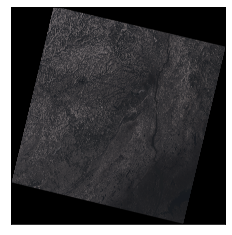

In [15]:
# Bands in a list start from 0, so RGB is no 432, but a 321 combination
ep.plot_rgb(arr_land,
            rgb=(3, 2, 1),
            figsize=(4, 4))
plt.show()

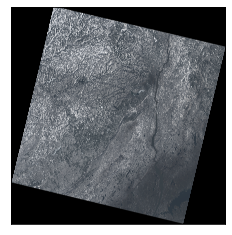

In [16]:
# RGB Composite Image with Stretching Histogram to make pixels brighter
ep.plot_rgb(arr_land,
            rgb=(3, 2, 1),
            stretch=True,
            str_clip=0.2,
            figsize=(4, 4))
plt.show()

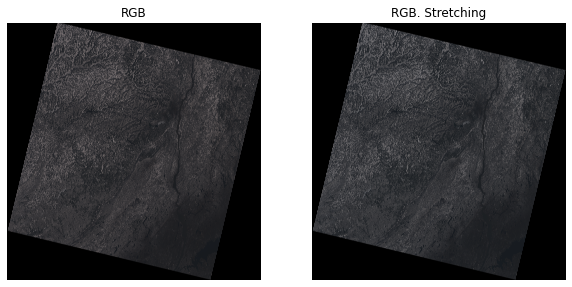

In [23]:
# RGB and RGB Stretching side by side
rgb = np.moveaxis(np.stack([list[3], list[2], list[1]]), 0, -1)
Image = rgb/np.amax(rgb)


import mahotas
Image2 = mahotas.stretch_rgb(Image)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(Image)
ax.set_title('RGB')
plt.axis('off')

ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(Image2)
ax.set_title('RGB. Stretching')
plt.axis('off')

plt.show()

<h3>Normalized Difference Vegetation Index (NDVI)</h3>

The normalized difference vegetation index (NDVI) is a simple graphical indicator that can be used to analyze remote sensing measurements, often from a space platform, assessing whether or not the target being observed contains live green vegetation.

NDVI = (NIR – Red) / (NIR + Red)

<h4>Visual interpretation of the output image/raster created:</h4>

<ul>
<li>-1 to 0 - bright surface with no vegetation or water content</li>
<li>+1 - represent water content</li>
</ul>

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [7]:
# NIR is the 5th band, but 5-1=4 in a list, starting from 0
# Red is the 4th band, but 4-1=3 in a list, starting from 0

ndvi = es.normalized_diff(arr_land[4], arr_land[3])

C:\Users\permyakov\Anaconda3\lib\site-packages\earthpy\spatial.py:109: Warning: Divide by zero produced infinity values that will be replaced with nan values
  warnings.warn(


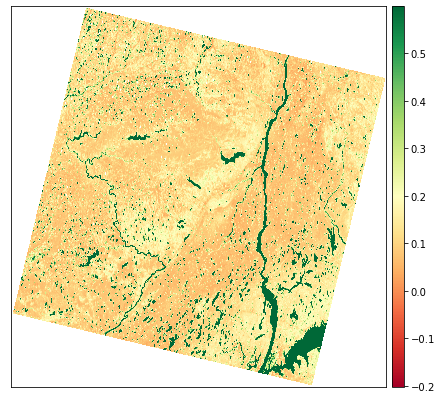

In [24]:
ep.plot_bands(ndvi,
              cmap='RdYlGn',
              vmin=-0.202,
              vmax=0.599,
              figsize=(15, 7))
plt.show()

<h3>Normalized Difference Water Index (NDWI). Formula 1</h3>

Normalized Difference Water Index (NDWI) may refer to one of at least two remote sensing-derived indexes related to liquid water.
<ul>
<li>One is used to monitor changes in water content of leaves, using near-infrared (NIR) and short-wave infrared (SWIR) wavelengths:</li>

NDWI = (NIR – SWIR) / (NIR + SWIR), proposed by Gao in 1996

<h4>Visual interpretation of the output image/raster created:</h4>

<ul>
<li>-1 to 0 - bright surface with no vegetation or water content</li>
<li>+1 - represent water content</li>
</ul>

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [19]:
# NIR is the 5th band, but 5-1=4 in a python list, starting from 0
# SWIR is the 7th band, but 7-1=6 in a python list, starting from 0

ndwi_land = es.normalized_diff(b1=arr_land[4],
                              b2=arr_land[6])

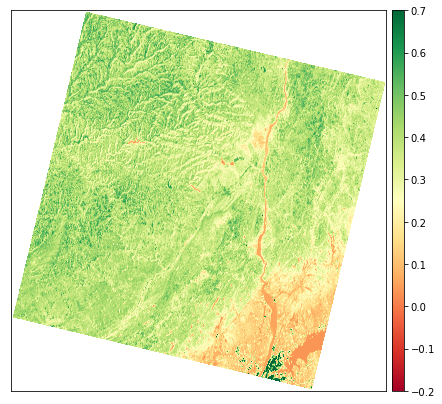

In [20]:
ep.plot_bands(ndwi_land,
              cmap='RdYlGn',
              vmin=-0.2,
              vmax=0.7,
              figsize=(15, 7))
plt.show()

<h3>Normalized Difference Water Index (NDWI). Formula 2</h3>

<li>Another is used to monitor changes related to water content in water bodies, using green and NIR wavelengths:</li>

NDWI = (Green – NIR) / (Green + NIR), defined by McFeeters in 1996

<h4>Visual interpretation of the output image/raster created:</h4>

<ul>

<li>< 0.3 - Non-water</li>
<li>>= 0.3 - Water</li>
</ul>

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [15]:
# Green is the 3rd band, but 3-1=2 in a python list, starting from 0
# NIR is the 5th band, but 5-1=4 in a python list, starting from 0

ndwi2_land = es.normalized_diff(b1=arr_land[2],
                               b2=arr_land[4])

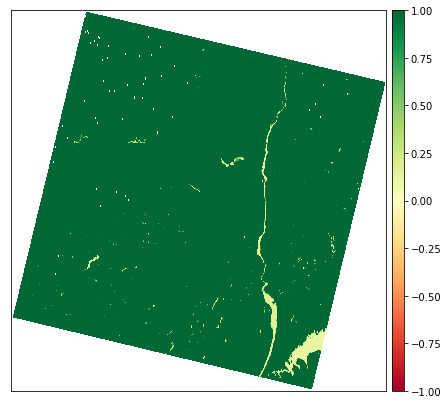

In [18]:
ep.plot_bands(ndwi2_land,
              cmap='RdYlGn',
              vmin=-1,
              vmax=1,
              figsize=(15, 7))
plt.show()

<h3>Soil-Adjusted Vegetation Index (SAVI)</h3>

Landsat Soil Adjusted Vegetation Index (SAVI) is used to correct Normalized Difference Vegetation Index (NDVI) for the influence of soil brightness in areas where vegetative cover is low.

SAVI = ((NIR - Red) / (NIR + Red + L)) x (1 + L)

<ul>
<li>NIR = pixel values from the near infrared band</li>
<li>Red = pixel values from the near red band</li>
<li>L = amount of green vegetation cover</li>
</ul>

<h4>Visual interpretation of the output image/raster created:</h4>

The L value varies depending on the amount of green vegetative cover: 
<ul>
<li>Generally, in areas with no green vegetation cover, L=1;</li> 
<li>In areas of moderate green vegetative cover, L=0.5;</li> 
<li>In areas with very high vegetation cover, L=0 (which is equivalent to the NDVI method).</li> 

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [8]:
# NIR is the 5th band, but 5-1=4 in a list, starting from 0
# Red is the 4th band, but 4-1=3 in a list, starting from 0
L = 0.5
savi = ((arr_land[4] - arr_land[3]) / (arr_land[4] + arr_land[3] + L)) * (1 + L)

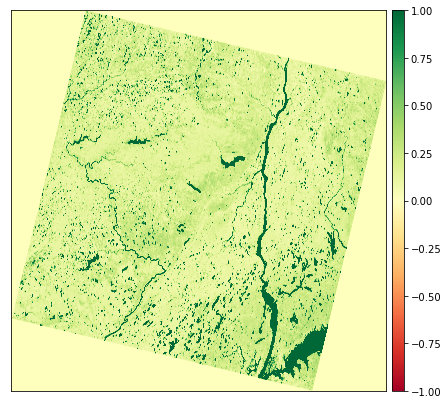

In [25]:
ep.plot_bands(savi,
              cmap="RdYlGn",
              cols=1,
              vmin=-1,
              vmax=1,
              figsize=(15, 7))
plt.show()

<h3>Visible Atmospherically Resistant Index (VARI)</h3>

The Visible Atmospherically Resistant Index (VARI) is designed to emphasize vegetation in the visible portion of the spectrum while mitigating illumination differences and atmospheric effects. It is ideal for RGB or color images; it utilizes all three color bands.

VARI = (Green - Red)/ (Green + Red - Blue)

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [17]:
# Red is the 4th band, but 4-1=3 in a python list, starting from 0
# Green is the 3th band, but 3-1=2 in a python list, starting from 0
# Blue is the 2nd band, but 2-1=1 in a python list, starting from 0
vari = (arr_land[2] - arr_land[3])/ (arr_land[2] + arr_land[3] - arr_land[1])

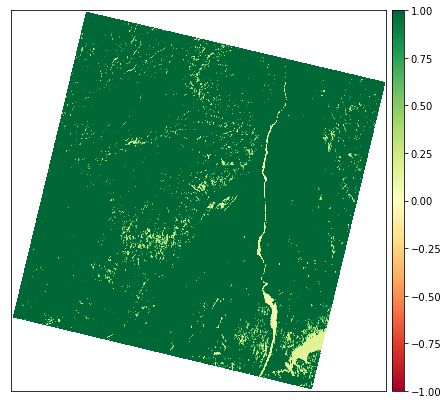

In [27]:
ep.plot_bands(vari,
              cmap="RdYlGn",
              cols=1,
              vmin=-1,
              vmax=1,
              figsize=(15, 7))
plt.show()

<h4> NDVI, SAVI. Histograms</h4>

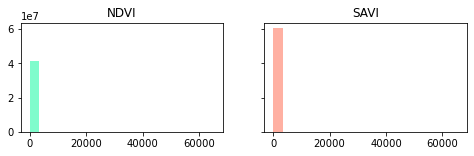

In [22]:
ep.hist(np.stack([ndvi, savi]), 
        alpha=0.5,
        cols=2, 
        figsize=(8, 2),
        title = ['NDVI', 'SAVI'],
        colors = ['mediumspringgreen', 'tomato'])
plt.show()

<h3>Modified Normalized Difference Water Index (MNDWI)</h3>

The Modified Normalized Difference Water Index (MNDWI) uses green and SWIR bands for the enhancement of open water features. It also diminishes built-up area features that are often correlated with open water in other indices.

MNDWI = (Green - SWIR) / (Green + SWIR)

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [23]:
# Green is the 3th band, but 3-1=2 in a python list, starting from 0
# SWIR is the 6th band, but 6-1=5 in a python list, starting from 0
mndwi = es.normalized_diff(arr_land[2], arr_land[5])

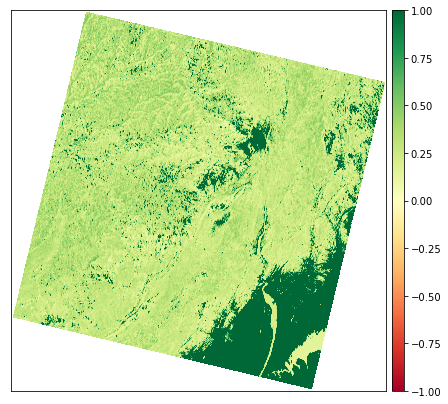

In [24]:
ep.plot_bands(mndwi,
              cmap="RdYlGn",
              cols=1,
              vmin=-1,
              vmax=1,
              figsize=(15, 7))
plt.show()

<h3>Normalized Difference Moisture Index (NDMI)</h3>

The Normalized Difference Moisture Index (NDMI) is sensitive to the moisture levels in vegetation. It is used to monitor droughts as well as monitor fuel levels in fire-prone areas. It uses NIR and SWIR bands to create a ratio designed to mitigate illumination and atmospheric effects.

NDMI = (NIR - SWIR1)/(NIR + SWIR1)

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [16]:
# NIR is the 5th band, but 5-1=4 in a python list, starting from 0
# SWIR1 is the 6th band, but 6-1=5 in a python list, starting from 0
ndmi = es.normalized_diff(arr_land[4], arr_land[5])

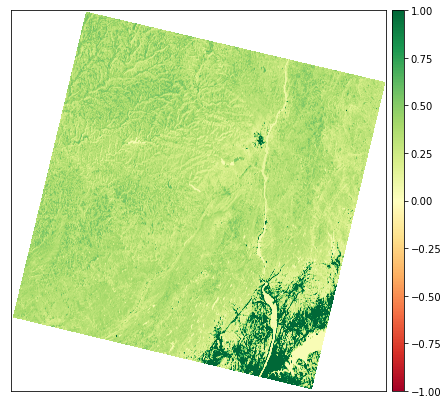

In [17]:
ep.plot_bands(ndmi,
              cmap="RdYlGn",
              cols=1,
              vmin=-1,
              vmax=1,
              figsize=(15, 7))
plt.show()

<h3>Clay Minerals</h3>

The clay ratio is a ratio of the SWIR1 and SWIR2 bands. This ratio leverages the fact that hydrous minerals such as clays, alunite absorb radiation in the 2.0–2.3 micron portion of the spectrum. This index mitigates illumination changes due to terrain since it is a ratio.

Clay Minerals Ratio = SWIR1 / SWIR2

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [32]:
# SWIR1 is the 6th band, but 6-1=5 in a python list, starting from 0
# SWIR2 is the 7th band, but 7-1=6 in a python list, starting from 0
cmr = np.divide(arr_land[5], arr_land[6])

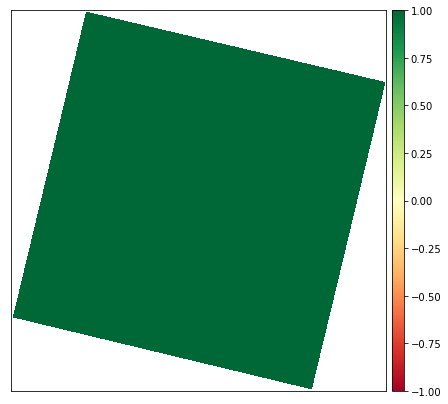

In [37]:
ep.plot_bands(cmr,
              cmap="RdYlGn",
              cols=1,
              vmin=-1,
              vmax=1,
              figsize=(15, 7))
plt.show()

<h3>Ferrous Minerals</h3>

The ferrous minerals ratio highlights iron-bearing materials. 

Ferrous Minerals Ratio = SWIR / NIR

<div>
<img src="https://miro.medium.com/max/1400/0*EOLdGGHYqGMAitga." width="500" height="500" align="left"/>
</div>

In [20]:
# SWIR1 is the 6th band, but 6-1=5 in a python list, starting from 0
# NIR is the 5th band, but 5-1=6 in a python list, starting from 0
fmr = np.divide(arr_land[5], arr_land[6])

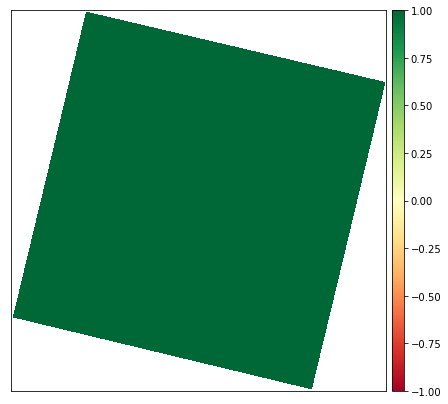

In [21]:
ep.plot_bands(fmr,
              cmap="RdYlGn",
              cols=1,
              vmin=-1,
              vmax=1,
              figsize=(15, 7))
plt.show()